##### This here is the data pipeline of the ACDC dataset

In [ ]:

import torch 
import torchio as tio

from torchvision import transforms
import torchvision.transforms.functional as F
import torch.nn.functional as f
import torchvision.ops as ops
from torchvision.transforms import Compose
from torch.utils.data import Dataset, DataLoader

import os
import matplotlib.pyplot as plt
import numpy as np

c:\Users\kajou\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_path = "/Users/kajou/OneDrive/Desktop/VQ-VAE/ACDC/database/training"

#### Defining the dataset : 

Now, for our specefic case , knowing that we will work on only the segmentations of the cardiac shapes, and knoowing that the ACDC dataset provides 100 patients in training and50 in testing which isn't big in the context of dataBases, we prefer to call all the segmetations on a list for the easy usage, in other contexts where the dataSet is so large this solution may rapidly cause Resources exhaustion. that's why it is prefered to go through the Dataset class where you provide the path of your data, and let it handle the fecths from disk at each batch.

In [ ]:
# The following paramerters are set according to the VQ-VAE paper.

L = 64 # image size L=W
BATCH_SIZE = 128


In [4]:
def get_max_BB(D3_slice):
    masks = (D3_slice > 0).float()

    # boxes = ops.masks_to_boxes(binary_masks)
    boxes = []
    for mask in masks:
        # Get coordinates of non-zero pixels
        y, x = torch.where(mask)
        
        if len(y) == 0:  # Empty mask
            continue
            
        # Compute box coordinates
        box = [
            x.min(), y.min(),
            x.max(), y.max()
        ]
        
        boxes.append(box)
        
    boxes = torch.tensor(boxes)
    largest_box = torch.tensor([
        boxes[:, 0].min(),  # smallest x1
        boxes[:, 1].min(),  # smallest y1
        boxes[:, 2].max(),  # largest x2
        boxes[:, 3].max()   # largest y2
    ])
    return largest_box

def to_square_BB(BB):
    min_col, min_row,max_col, max_row = BB
    L = max_col - min_col
    W = max_row - min_row
    d = np.abs(L-W)
    eps_left = d//2 
    eps_right = d-eps_left
    if L>W : 
        min_row -= eps_left
        max_row += eps_right
    else : 
        min_col -= eps_left
        max_col += eps_right
    return [min_col, min_row, max_col, max_row]


def add_background_BB(suqare_BB,n_p = 10):
    min_col, min_row, max_col, max_row = suqare_BB

    min_col -= n_p
    min_row -= n_p
    max_row += n_p
    max_col += n_p
    BB_bg = [min_col, min_row, max_col, max_row]
    return BB_bg

def crop_img(D3_slice):
    # BB = ops.masks_to_boxes(img.unsqueeze(0))[0].int().numpy()
    BB = get_max_BB(D3_slice)
    BB = to_square_BB(BB)
    BB = add_background_BB(BB)
    min_col, min_row,max_col, max_row = BB

    img = D3_slice
    croped = F.crop(img, min_row, min_col, max_row-min_row, max_col-min_col)
    return croped

In [5]:
dataset_path = "/Users/kajou/OneDrive/Desktop/VQ-VAE/ACDC/database"

patients = os.listdir(os.path.join(dataset_path, "training"))[1:]
print(patients)
patient_PATH  = os.path.join(dataset_path, "training", "patient002")
files = os.listdir(patient_PATH)
image_files = [f for f in files if f.endswith('.nii.gz') and not f.endswith('_gt.nii.gz') and not f.endswith('4d.nii.gz')]
frames = [f.split('_')[1].split('.')[0] for f in image_files ]

print(max(frames))

['patient001', 'patient002', 'patient003', 'patient004', 'patient005', 'patient006', 'patient007', 'patient008', 'patient009', 'patient010', 'patient011', 'patient012', 'patient013', 'patient014', 'patient015', 'patient016', 'patient017', 'patient018', 'patient019', 'patient020', 'patient021', 'patient022', 'patient023', 'patient024', 'patient025', 'patient026', 'patient027', 'patient028', 'patient029', 'patient030', 'patient031', 'patient032', 'patient033', 'patient034', 'patient035', 'patient036', 'patient037', 'patient038', 'patient039', 'patient040', 'patient041', 'patient042', 'patient043', 'patient044', 'patient045', 'patient046', 'patient047', 'patient048', 'patient049', 'patient050', 'patient051', 'patient052', 'patient053', 'patient054', 'patient055', 'patient056', 'patient057', 'patient058', 'patient059', 'patient060', 'patient061', 'patient062', 'patient063', 'patient064', 'patient065', 'patient066', 'patient067', 'patient068', 'patient069', 'patient070', 'patient071', 'pati

In [6]:
dataset_path = "/Users/kajou/OneDrive/Desktop/VQ-VAE/ACDC/database"

def load_patient_gt(patient_PATH) :
    files = os.listdir(patient_PATH)
    image_files = [f for f in files if f.endswith('.nii.gz') and not f.endswith('_gt.nii.gz') and not f.endswith('4d.nii.gz')]
    gt_files = [f for f in files if f.endswith('_gt.nii.gz')]


    # Identify ED and ES frames
    frames = [f.split('_')[1].split('.')[0] for f in image_files ]
    ed_frame = min(frames)
    es_frame = max(frames)

    # Load ground truth segmentations
    ed_gt = tio.LabelMap(os.path.join(patient_PATH, f"patient{patient_PATH[-3:]}_{ed_frame}_gt.nii.gz"))
    es_gt = tio.LabelMap(os.path.join(patient_PATH, f"patient{patient_PATH[-3:]}_{es_frame}_gt.nii.gz"))
    ed_gt_slices = crop_img(ed_gt.data.squeeze(0).permute(2,0,1)).flatten(start_dim = 0, end_dim=0) 
    es_gt_slices = crop_img(es_gt.data.squeeze(0).permute(2,0,1)).flatten(start_dim = 0, end_dim=0)


    return [tensor for tensor in ed_gt_slices] + [tensor for tensor in es_gt_slices]

def load_dataset(Path):
    dataset = []
    patients = os.listdir(Path)[1:]
    for patient in patients : 
        patient_gt = load_patient_gt(os.path.join(Path, patient)) 
        dataset  += patient_gt
    return dataset


train_dataset = load_dataset(os.path.join(dataset_path, "training"))
test_dataset = load_dataset(os.path.join(dataset_path, "testing"))

In [7]:
print(len(train_dataset))

1902


torch.Size([103, 103])


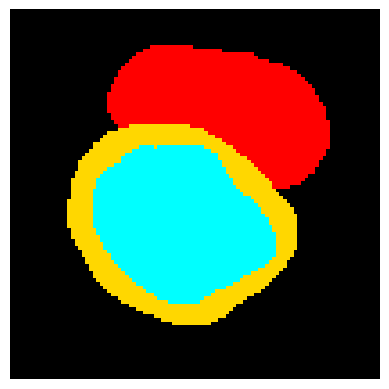

In [8]:
from matplotlib.colors import ListedColormap
custom_colors = [
    '#000000', '#ff0000', '#ffd700', '#00ffff']

cmap = ListedColormap(custom_colors)

slice = train_dataset[20]
plt.imshow(slice , cmap)
plt.axis('off')

print(slice.shape)

In [9]:
train_dataset[1001].unsqueeze(0).shape

torch.Size([1, 84, 84])

In [10]:
class One_hot_Transform:
    def __init__(self, num_classes):
        self.num_classes = num_classes
    
    def __call__(self, x):
        x = x.squeeze(0).long()
        one_hot_encoded = f.one_hot(x, num_classes=4)
        return one_hot_encoded.permute(2, 0, 1)
        
input_transforms = Compose([
    transforms.Resize(size=(L,L), interpolation=transforms.InterpolationMode.NEAREST),
    One_hot_Transform(num_classes=4)
    ])

#define the dataset

class ACDC_slices(Dataset):
    def __init__(self, data, transforms =None):
        self.data = data
        self.transforms = transforms

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        item = item.unsqueeze(0)  # Shape: (1, H, W)

        if self.transforms:
            item = self.transforms(item)

        return item
    
TrainDataset = ACDC_slices(data = train_dataset, transforms= input_transforms) 
TestDataset  = ACDC_slices(data = test_dataset, transforms= input_transforms)

TrainLoader  = DataLoader(TrainDataset, batch_size = BATCH_SIZE, shuffle = True)
TestLoader   = DataLoader(TestDataset , batch_size = BATCH_SIZE, shuffle = True)

batch = next(iter(TrainLoader))

In [11]:
batch.shape[0]

128

Batch of images shape: torch.Size([128, 4, 64, 64])
Batch of segmentations shape: torch.Size([128, 4, 64, 64])


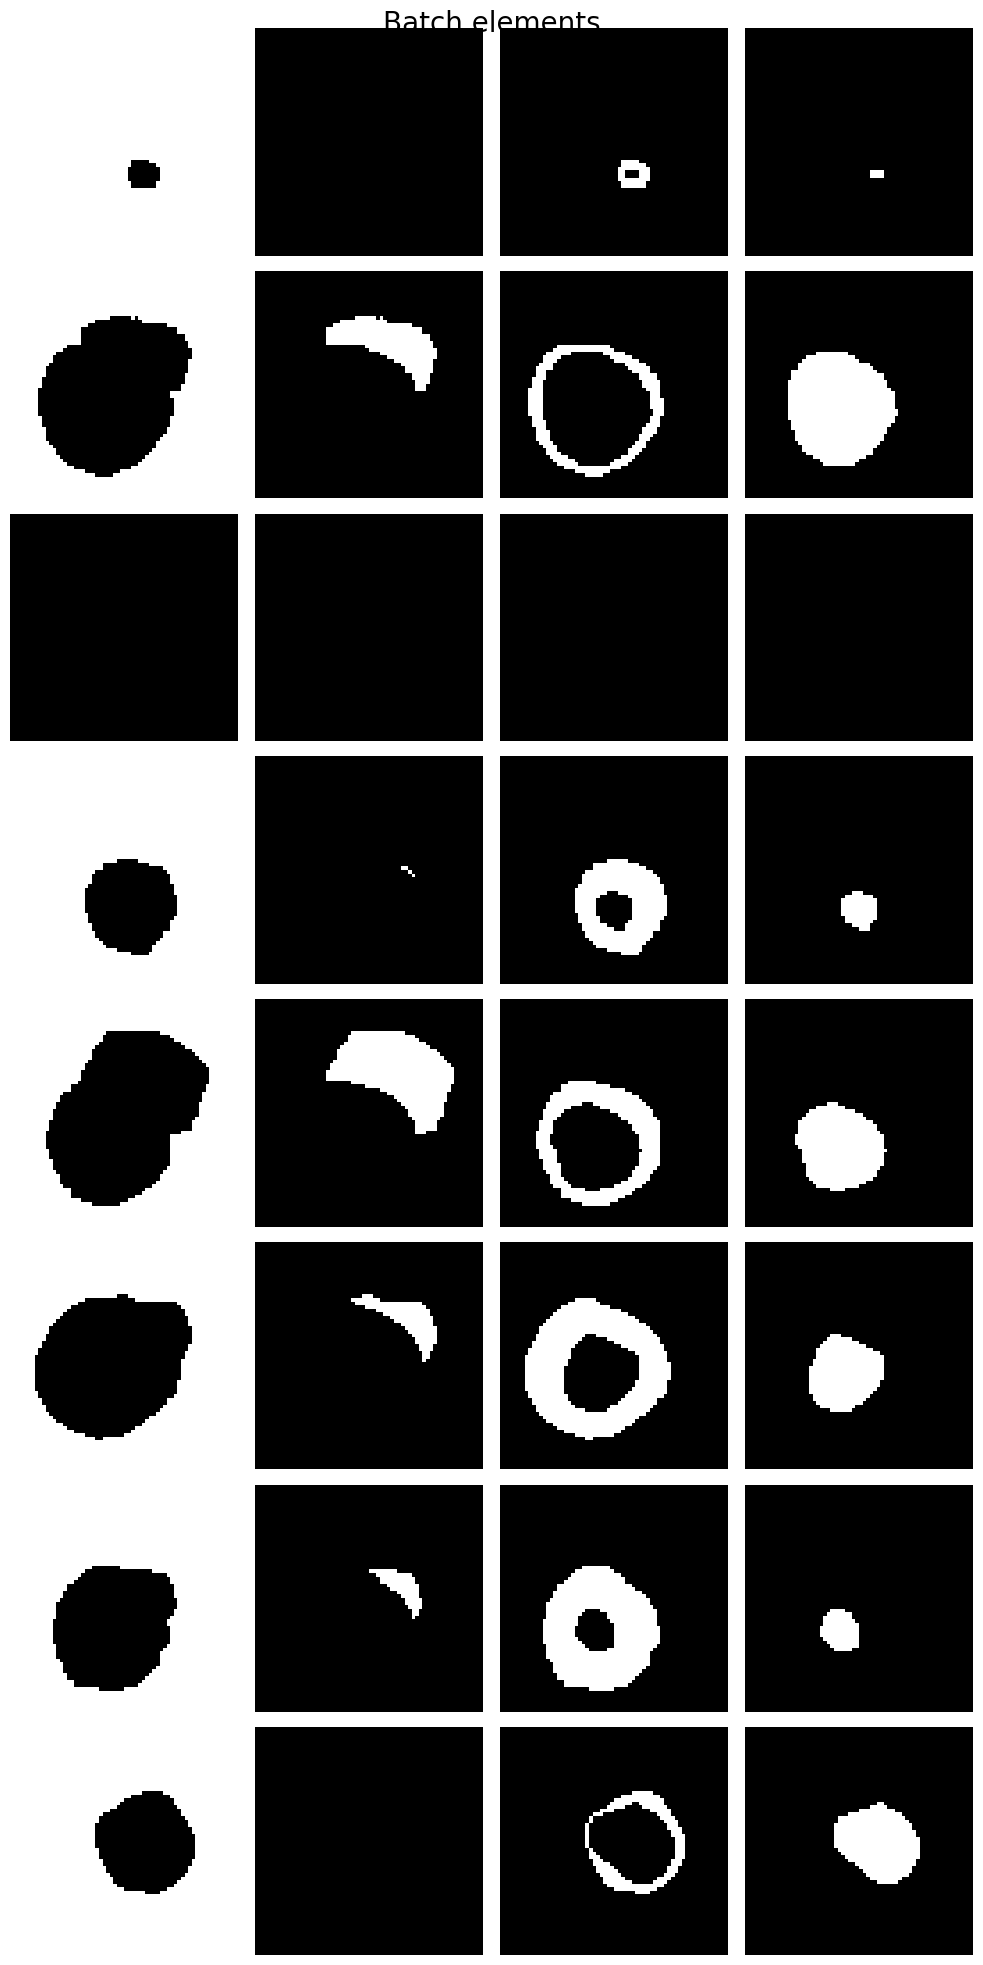

In [12]:
batch = next(iter(TrainLoader))
def visualize_batch(batch):
    batch_size = batch.shape[0]
    samples = 8


    fig, axes = plt.subplots(samples, 4, figsize=(10, 20))  # Adjust figsize to accommodate more rows
    fig.suptitle('Batch elements', fontsize=20)


    for ax in axes.flat:
        ax.set_axis_off()

    for i in range(samples):

        img = batch[i]
        axes[i,0].imshow(img[0,:,:], cmap = 'gray')
        axes[i,1].imshow(img[1,:,:], cmap = 'gray')
        axes[i,2].imshow(img[2,:,:], cmap = 'gray')
        axes[i,3].imshow(img[3,:,:], cmap = 'gray')
        # axes[i].axis('off')

    
    plt.tight_layout()
    plt.show()

# Example usage:
# Visualize the first batch
print(f"Batch of images shape: {batch.shape}")
print(f"Batch of segmentations shape: {batch.shape}")
visualize_batch(batch)

In [ ]:
from torch.nn import functional as F



In [87]:
batch.shape
target = 2*torch.rand(128,4,64,64)
F.binary_cross_entropy_with_logits(target, batch.float(), reduction='sum')

tensor(2298972.7500)